In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

import warnings
from pathlib import Path

# FE
from scipy.signal import find_peaks, peak_widths, peak_prominences

from sklearn.model_selection import train_test_split

import gc
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score, StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import log_loss, matthews_corrcoef, roc_auc_score
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
import contextlib

from sklearn.metrics import accuracy_score

from skopt import BayesSearchCV
from sklearn.model_selection import StratifiedKFold

In [4]:
pd.set_option('max_columns', 100)
pd.set_option('display.precision', 4)

rcParams['figure.figsize'] = (16, 8)
plt.style.use('fivethirtyeight')
sns.set(font_scale=2.5)

warnings.filterwarnings('ignore')

# 데이터 로드

In [5]:
data_dir = Path('../input/dankook')
sub_dir = Path('../output/')

train_file = data_dir / 'train.csv'
test_file = data_dir / 'test.csv'
sample_file = data_dir / 'sample_submission.csv'
sub_file = sub_dir / 'submission.csv'

SEED = 2020

In [6]:
df_train = pd.read_csv(train_file, index_col=0)
df_test = pd.read_csv(test_file, index_col=0)

# 변수 생성

ver1: 앞뒤 컬럼의 차이를 변수로 생성

ver2: 5개 컬럼 전의 컬럼과의 차이까지 변수로 생성

In [7]:
wave_columns = df_train.columns.drop(['nObserve','nDetect','class','redshift'])

## Ver1

In [8]:
for j in range(14):
    name = 'diff_' + str(wave_columns[j+1]) + '_' + str(wave_columns[j])
    df_train[name] = df_train[wave_columns[j+1]] - df_train[wave_columns[j]]
    df_test[name] = df_test[wave_columns[j+1]] - df_test[wave_columns[j]]
    print(wave_columns[j+1], ' - ', wave_columns[j], j)

g  -  u 0
r  -  g 1
i  -  r 2
z  -  i 3
dered_u  -  z 4
dered_g  -  dered_u 5
dered_r  -  dered_g 6
dered_i  -  dered_r 7
dered_z  -  dered_i 8
airmass_u  -  dered_z 9
airmass_g  -  airmass_u 10
airmass_r  -  airmass_g 11
airmass_i  -  airmass_r 12
airmass_z  -  airmass_i 13


In [9]:
# 15포인트 랭킹

mag_rank_tr = df_train[wave_columns].rank(axis=1)
mag_rank_tt = df_test[wave_columns].rank(axis=1)

rank_col = []
for col in df_train[wave_columns].columns:
    col = col + '_rank'
    rank_col.append(col)
mag_rank_tr.columns = rank_col
mag_rank_tt.columns = rank_col

df_train = pd.concat([df_train, mag_rank_tr], axis=1)
df_test = pd.concat([df_test,mag_rank_tt], axis=1)

In [10]:
# 측정방법별 파장 차이 비교 변수

diff_col = []
for col in ['u','g','r','i','z']:
    for i in range(2):
        diff_col.append(col + '_' + str(i))

mag_wave_diff_tr = pd.DataFrame(np.zeros((df_train.shape[0], 10)), index=df_train.index)
mag_wave_diff_tt = pd.DataFrame(np.zeros((df_test.shape[0],10)), index=df_test.index)

for i in range(0,10,5):
    for j in range(5):
        mag_wave_diff_tr.loc[:, j+i] = df_train[wave_columns[j]] - df_train[wave_columns[5+j+i]]
        mag_wave_diff_tt.loc[:, j+i] = df_test[wave_columns[j]] - df_test[wave_columns[5+j+i]]
        print(wave_columns[j], ' - ', wave_columns[5+j+i],i+j)

u  -  dered_u 0
g  -  dered_g 1
r  -  dered_r 2
i  -  dered_i 3
z  -  dered_z 4
u  -  airmass_u 5
g  -  airmass_g 6
r  -  airmass_r 7
i  -  airmass_i 8
z  -  airmass_z 9


In [11]:
mag_wave_diff_tr.columns = diff_col
mag_wave_diff_tt.columns = diff_col

df_train = pd.concat([df_train, mag_wave_diff_tr], axis=1)
df_test = pd.concat([df_test, mag_wave_diff_tt], axis=1)



In [12]:
df_train['nObserve'] = df_train['nObserve'].apply(np.log1p)
df_test['nObserve'] = df_test['nObserve'].apply(np.log1p)

df_train['d_obs_det'] = df_train['nObserve'] - df_train['nDetect']
df_test['d_obs_det'] = df_test['nObserve'] - df_test['nDetect']

In [13]:
delete_column=['u','g','r','i','nDetect',
               'airmass_g', 'airmass_r', 'airmass_i', 'airmass_z',
               'dered_u','dered_g','dered_r','dered_i',
               'diff_airmass_g_airmass_u','diff_airmass_r_airmass_g',
               'diff_airmass_i_airmass_r',
               'airmass_u_rank', 'airmass_g_rank', 'airmass_r_rank',
               'airmass_i_rank',
              ]

In [14]:
df_train.drop(delete_column, axis=1, inplace=True)
df_test.drop(delete_column, axis=1, inplace=True)

# 데이터셋 생성

In [15]:
# train set
X = df_train.drop(columns=['class'], axis=1)
y = df_train.loc[:,'class']

# test set
test = df_test

# train set split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=2020)

# feature 선택

In [16]:
df_train.head()

,z,redshift,dered_z,nObserve,airmass_u,class,diff_g_u,diff_r_g,diff_i_r,diff_z_i,diff_dered_u_z,diff_dered_g_dered_u,diff_dered_r_dered_g,diff_dered_i_dered_r,diff_dered_z_dered_i,diff_airmass_u_dered_z,diff_airmass_z_airmass_i,u_rank,g_rank,r_rank,i_rank,z_rank,dered_u_rank,dered_g_rank,dered_r_rank,dered_i_rank,dered_z_rank,airmass_z_rank,u_0,u_1,g_0,g_1,r_0,r_1,i_0,i_1,z_0,z_1,d_obs_det
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,16.9396,-8.1086e-05,16.9089,2.9444,1.1898,0,-2.9272,-1.3273,-1.3371,-0.7328,6.1847,-2.8665,-1.3027,-1.3230,-0.7232,-15.7192,0.0009,15.0,13.0,11.0,9.0,7.0,14.0,12.0,10.0,8.0,6.0,4.0,0.1397,0.0790,0.0544,0.0403,0.0307,22.0742,19.1461,17.8205,16.4831,15.7494,-15.0556
1,13.1689,4.5061e-03,13.1347,0.6931,1.2533,1,-0.9902,-0.6096,-0.1840,-0.0995,1.7975,-0.9619,-0.5931,-0.1751,-0.1016,-11.8814,0.0045,15.0,13.0,11.0,9.0,7.0,14.0,12.0,10.0,8.0,6.0,4.0,0.0857,0.0574,0.0410,0.0322,0.0343,13.7989,12.8041,12.2037,12.0175,11.9134,-0.3069
2,15.3500,4.7198e-04,15.2961,1.0986,1.0225,0,-0.9610,-0.2891,-0.1428,-0.0435,1.2576,-0.9211,-0.2466,-0.1183,-0.0257,-14.2736,0.0016,15.0,13.0,11.0,9.0,8.0,14.0,12.0,10.0,7.0,6.0,4.0,0.1787,0.1388,0.0963,0.0718,0.0540,15.7639,14.8013,14.5153,14.3718,14.3267,-0.9014
3,19.6346,5.8143e-06,19.5552,1.6094,1.2054,0,-4.4719,-0.9676,-0.3262,-0.2603,5.7190,-4.3590,-0.9074,-0.2926,-0.2395,-18.3498,0.0006,15.0,13.0,11.0,9.0,7.0,14.0,12.0,10.0,8.0,6.0,4.0,0.3070,0.1941,0.1339,0.1003,0.0795,24.4552,19.9827,19.0163,18.6898,18.4289,-1.3906
4,17.9826,-3.3247e-05,17.8759,2.6391,1.1939,0,-3.7543,-1.6568,-0.7182,-0.3415,5.7888,-3.3376,-1.5709,-0.6727,-0.3144,-16.6820,0.0003,15.0,13.0,11.0,9.0,7.0,14.0,12.0,10.0,8.0,6.0,4.0,0.6820,0.2653,0.1794,0.1339,0.1067,23.2595,19.5049,17.8486,17.1303,16.7885,-9.3609


In [17]:
# Xgboost
xgb_params = {
    'n_jobs' : -1, 
    'n_estimators': 100,
    'eval_metric': 'mlogloss',
    'eta': 0.3, # learning_rate
    'booster': 'gbtree',
    'tree_method': 'auto',
    'objective': 'multi:softmax',
    'num_class': 3,
    'random_state': 2020
}

In [17]:
xgb_clf = xgb.XGBClassifier(**xgb_params)

In [18]:
xgb_clf.fit(X_train,y_train)
p = xgb_clf.predict(X_test)
print(accuracy_score(p,y_test))

0.9329895833333334


In [19]:
import eli5

In [20]:
from eli5.sklearn import PermutationImportance


In [21]:
perm = PermutationImportance(xgb_clf, random_state=2020).fit(X_test,y_test)

In [22]:
eli5.show_weights(perm, top = 80, feature_names = X_test.columns.tolist())

Weight,Feature
0.4344 ± 0.0014,redshift
0.0365 ± 0.0008,diff_dered_i_dered_r
0.0346 ± 0.0011,diff_dered_r_dered_g
0.0313 ± 0.0011,diff_dered_g_dered_u
0.0152 ± 0.0015,diff_i_r
0.0111 ± 0.0004,diff_r_g
0.0021 ± 0.0004,diff_dered_z_dered_i
0.0020 ± 0.0001,diff_dered_u_z
0.0016 ± 0.0002,diff_airmass_u_dered_z
0.0014 ± 0.0005,dered_z


<AxesSubplot:>

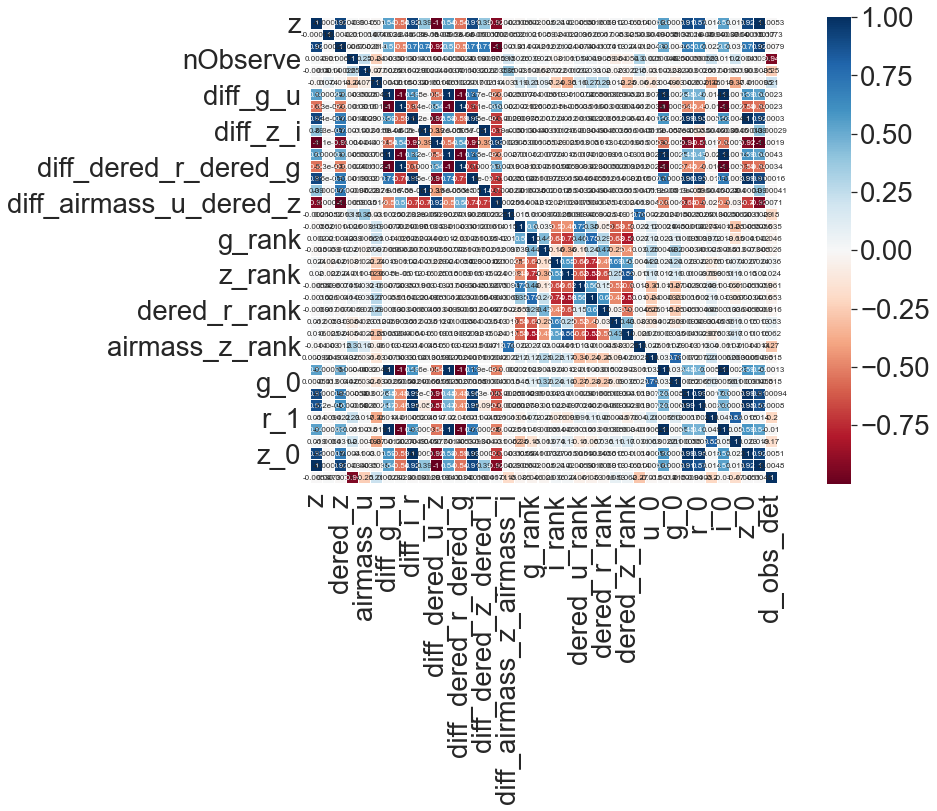

In [18]:
sns.heatmap(df_train.corr(), linewidths=0.1, vmax=1.0, square=True, cmap= plt.cm.RdBu, linecolor='white', annot=True, annot_kws={'size':8})